# Sentiment Classification for Data Analytics MSc Project

#### Importing necessary packages

In [2]:
# Import necessary packages

import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tabulate

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from tqdm import tqdm

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import opinion_lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

print(f"My Pytorch version is {torch.__version__}")

My Pytorch version is 2.0.1+cu118


In [3]:
torch.cuda.is_available()

True

In [24]:
data_dir = "../data/"

DEVICE = torch.device('cuda')

CPU = torch.device('cpu')


In [ ]:
# import nltk
# nltk.download('omw-1.4')
# nltk.download("punkt")
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')
# nltk.download('opinion_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\benga\AppData\Roaming\nltk_data...


True

In [5]:
# to replace words with their dictionary equilvalent
lemmatizer = WordNetLemmatizer()

# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

### Preprocessing Tweets

#### Emoji Replacement

In [ ]:
#
pos_list=set(opinion_lexicon.positive())
neg_list=set(opinion_lexicon.negative())

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
STOP_WORDS = stopwords.words('english')

In [ ]:
#Parsing Emoji Dictionary

with open(join(data_dir,"Emoji_Dict.p"), "rb") as f:
    emoji_dict = pickle.load(f)
    emoji_dict = {v: k for k, v in emoji_dict.items()} # Reverses dictionary so emojis are keys


#Extracts only sentiment words in emoji descriptions
for k,v in emoji_dict.items():
    raw = v.replace(":","")
    tokens = raw.split("_")
    lem_list = [lemmatizer.lemmatize(t) for t in tokens] #Lemmatising first to give better chance of finding in wordlists
    sentiment_tokens = [t for t in lem_list if t in pos_list or t in neg_list] # keeps only sentiment tokens
    emoji_dict[k]=" ".join(set(sentiment_tokens)) # using set to remove any duplicates


# Checks each word in text if its in the dict and replaces it if found
def convert_emojis(text):
    # check if the text is not NaN
    if pd.notna(text):
        for word in text.split(" "):
            if word in emoji_dict:
                text = text.replace(word,emoji_dict[word])
    return text

In [ ]:
print(convert_emojis("emoji_1: 😊 \nemoji_2: 😂 \nemoji_3: 😞"))

emoji_1: smiling 
emoji_2: joy 
emoji_3: disappointed


#### Slang Replacement

In [ ]:
from slang_dictionary import slang_dict

def convert_slang(text):
    # check if the text is not NaN
    if pd.notna(text):
        for word in text.split(" "):
            if word in slang_dict:
                text = text.replace(word,slang_dict[word])
    return text

print(convert_slang("lol this is so funny"))

laughing out loud this is so funny


#### Regular Expressions

In [ ]:
#Patterns

pos_emoticons = '(:|;|x|X|=)(\)|D|p|P|3)'
neg_emoticons = '(:|;|=)(\(|\{|\[)'

regex_websites = "https?:\/\/[^\s]+|www\.[^\s]+|[^\s]+\.(com|net|org|uk|ru|ir|in)|[^\s]+\.co\.[^ ]{2}"

regex_username = '(@)(\w+)'
# regex_hastag = '(#)(\w+)'

regex_nonAlpha = '[^a-zA-Z0-9\s]' #removing all non-alphanumeric characters except spaces
regex_digits = '\\b\d+\\b' #removing numbers fully made up of digits
regex_singleChar = '\\b\w\s\\b' #removing words that are only one charater long

#### Loading Tweet Dataset and Applying Pre-processing steps

In [ ]:
column_name = "text"
dataSet = pd.read_csv(data_dir+"bitcoin_tweets1000000.csv", usecols=[column_name], engine="c")
dataSet

,text
0,Blue Ridge Bank shares halted by NYSE after #b...
1,"😎 Today, that's this #Thursday, we will do a ""..."
2,"Guys evening, I have read this article about B..."
3,$BTC A big chance in a billion! Price: \487264...
4,This network is secured by 9 508 nodes as of t...
...,...
1000020,#wtfhappenedin1971? \n#Bitcoin will fix this!
1000021,@CryptoNadine @BabyArabiaBSC #babyarabia massi...
1000022,@mcuban Are you serious or part of the scam??\...
1000023,Why is #Bitcoin going to ascend to a global re...


In [ ]:
# Drop rows with non-string values in the "text" column
dataSet = dataSet[dataSet["text"].apply(lambda x: isinstance(x, str))]
dataSet

,text
0,Blue Ridge Bank shares halted by NYSE after #b...
1,"😎 Today, that's this #Thursday, we will do a ""..."
2,"Guys evening, I have read this article about B..."
3,$BTC A big chance in a billion! Price: \487264...
4,This network is secured by 9 508 nodes as of t...
...,...
1000020,#wtfhappenedin1971? \n#Bitcoin will fix this!
1000021,@CryptoNadine @BabyArabiaBSC #babyarabia massi...
1000022,@mcuban Are you serious or part of the scam??\...
1000023,Why is #Bitcoin going to ascend to a global re...


In [ ]:
# apply the lower function to the text column in the pandas data frame dataSet
dataSet.loc[:,"text"] = dataSet["text"].str.lower()

# apply the convert_emojis and then convert_slang functions to the text column in the pandas data frame dataSet
dataSet.loc[:,"text"] = dataSet["text"].apply(convert_emojis)
dataSet.loc[:,"text"] = dataSet["text"].apply(convert_slang)

# apply the replace function to the text column in the pandas data frame dataSet
dataSet.loc[:,"text"].replace(pos_emoticons, "happy", regex=True, inplace=True)
dataSet.loc[:,"text"].replace(neg_emoticons, "sad", regex=True, inplace=True)

dataSet.loc[:,"text"].replace(regex_websites,'',regex=True, inplace = True)

dataSet.loc[:,"text"].replace(regex_username,'',regex=True, inplace = True)
# dataSet["text"].replace(regex_hastag,'',regex=True, inplace = True)

dataSet.loc[:,"text"].replace(regex_nonAlpha,'',regex=True, inplace = True)
dataSet.loc[:,"text"].replace(regex_digits,'',regex=True, inplace = True)
dataSet.loc[:,"text"].replace(regex_singleChar,'',regex=True, inplace = True)

# apply the tokenizer function to the clean column in the pandas data frame dataSet
dataSet["tweet-text-tokenized"] = dataSet["text"].apply(tk.tokenize)

# remove stop words from each tweet using nltk library and store it back into a new column called "tweet-text-tokenized"
dataSet["tweet-text-tokenized"] = dataSet["tweet-text-tokenized"].apply(lambda tweet: [token for token in tweet if token not in STOP_WORDS])

# apply the lemmatizer function to the clean column in the pandas data frame dataSet
dataSet["tweet-text-tokenized"] = dataSet["tweet-text-tokenized"].apply(lambda tweet: [lemmatizer.lemmatize(token) for token in tweet])

# apply the detokenizer function to the clean column in the pandas data frame dataSet
# dataSet["clean"] = dataSet["tweet-text-tokenized"].apply(lambda x: TreebankWordDetokenizer().detokenize(x))

C:\Users\benga\AppData\Local\Temp\ipykernel_30168\2032042118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet.loc[:,"text"] = dataSet["text"].str.lower()
C:\Users\benga\AppData\Local\Temp\ipykernel_30168\2032042118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet.loc[:,"text"] = dataSet["text"].apply(convert_emojis)
C:\Users\benga\AppData\Local\Temp\ipykernel_30168\2032042118.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

#### Determining Sentiment Targets based off Vader Scores

In [ ]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()

    # Create the "cleantext" column
    df["cleantext"] = df[label].apply(lambda x: TreebankWordDetokenizer().detokenize(x))

    vader_scores = df["cleantext"].apply(lambda x: sid.polarity_scores(x))

    # Extract individual Vader scores and assign them to new columns
    df["vader_neg"] = vader_scores.apply(lambda x: x["neg"])
    df["vader_neu"] = vader_scores.apply(lambda x: x["neu"])
    df["vader_pos"] = vader_scores.apply(lambda x: x["pos"])
    df["vader_comp"] = vader_scores.apply(lambda x: x["compound"])


    return df

In [ ]:
prep_dataSet = compute_vader_scores(dataSet,'tweet-text-tokenized')
prep_dataSet

C:\Users\benga\AppData\Local\Temp\ipykernel_30168\430584691.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cleantext"] = df[label].apply(lambda x: TreebankWordDetokenizer().detokenize(x))
C:\Users\benga\AppData\Local\Temp\ipykernel_30168\430584691.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["vader_neg"] = vader_scores.apply(lambda x: x["neg"])
C:\Users\benga\AppData\Local\Temp\ipykernel_30168\430584691.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

,text,tweet-text-tokenized,cleantext,vader_neg,vader_neu,vader_pos,vader_comp
0,blue ridge bank shares halted by nyse after bi...,"[blue, ridge, bank, share, halted, nyse, bitco...",blue ridge bank share halted nyse bitcoin atm ...,0.000,0.784,0.216,0.2960
1,smiling today thats this thursday we will do a...,"[smiling, today, thats, thursday, take, friend...",smiling today thats thursday take friend btc w...,0.000,0.449,0.551,0.8225
2,guys evening have read this article about btc ...,"[guy, evening, read, article, btc, would, like...",guy evening read article btc would like share,0.000,0.561,0.439,0.5719
3,btc big chance in billion price bitcoin fx ...,"[btc, big, chance, billion, price, bitcoin, fx...",btc big chance billion price bitcoin fx btc cr...,0.000,0.800,0.200,0.2500
4,this network is secured by nodes as of today...,"[network, secured, node, today, soon, biggest,...",network secured node today soon biggest bear r...,0.230,0.592,0.178,-0.2023
...,...,...,...,...,...,...,...
1000020,wtfhappenedin1971 \nbitcoin will fix this,"[wtfhappenedin, 1971, bitcoin, fix]",wtfhappenedin 1971 bitcoin fix,0.000,1.000,0.000,0.0000
1000021,babyarabia massive bitcoin rewards great dev...,"[babyarabia, massive, bitcoin, reward, great, ...",babyarabia massive bitcoin reward great dev te...,0.000,0.698,0.302,0.8316
1000022,are you serious or part of the scam\nor are y...,"[serious, part, scam, scammed, bsv, bitcoin, t...",serious part scam scammed bsv bitcoin thats ne...,0.263,0.737,0.000,-0.6124
1000023,why is bitcoin going to ascend to global reser...,"[bitcoin, going, ascend, global, reserve, curr...",bitcoin going ascend global reserve currency b...,0.155,0.633,0.212,0.4215


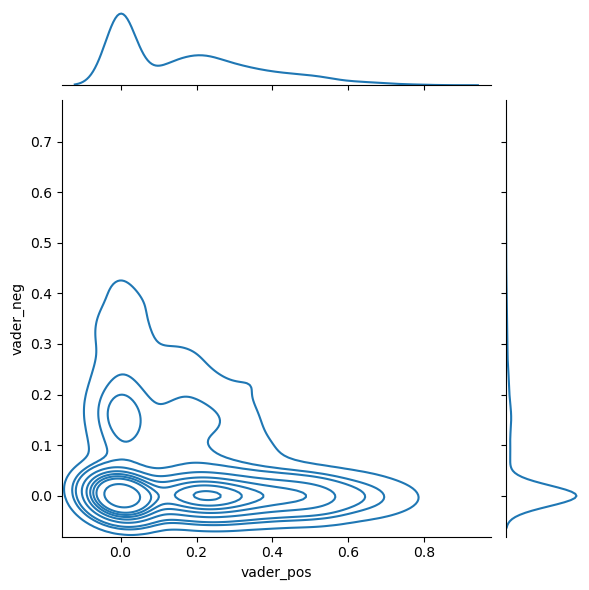

In [ ]:
sns.jointplot(data=prep_dataSet.sample(2000), x='vader_pos', y='vader_neg', kind="kde")

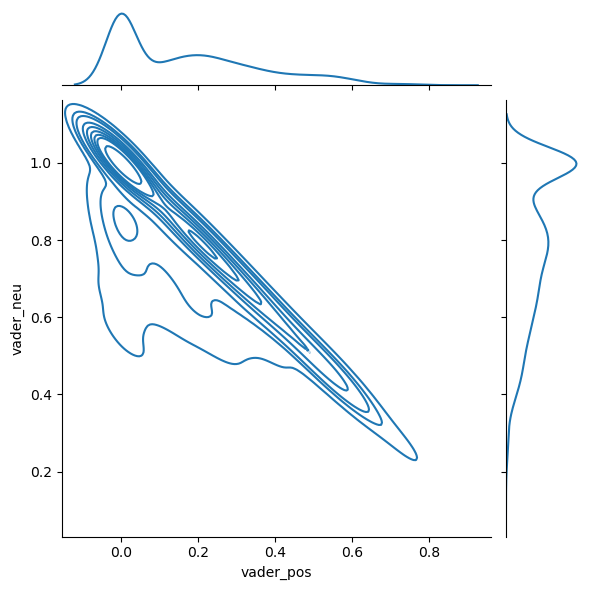

In [ ]:
sns.jointplot(data=prep_dataSet.sample(2000), x='vader_pos', y='vader_neu', kind="kde")

In [ ]:
class0=[]
for index, row in prep_dataSet.iterrows():
    if row['vader_neg']>0:
        class0+=[0]
    elif row['vader_pos']>0:
        class0+=[2]
    else:
        class0+=[1]

In [ ]:
class0

[2,
 2,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 2,
 0,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 0,
 2,
 0,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,


In [ ]:
prep_dataSet['class']=class0
prep_dataSet['class'].value_counts()

C:\Users\benga\AppData\Local\Temp\ipykernel_30168\1233005218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_dataSet['class']=class0


2    455433
1    305835
0    238725
Name: class, dtype: int64

In [ ]:
prep_dataSet

,text,tweet-text-tokenized,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,class
0,blue ridge bank shares halted by nyse after bi...,"[blue, ridge, bank, share, halted, nyse, bitco...",blue ridge bank share halted nyse bitcoin atm ...,0.000,0.784,0.216,0.2960,2
1,smiling today thats this thursday we will do a...,"[smiling, today, thats, thursday, take, friend...",smiling today thats thursday take friend btc w...,0.000,0.449,0.551,0.8225,2
2,guys evening have read this article about btc ...,"[guy, evening, read, article, btc, would, like...",guy evening read article btc would like share,0.000,0.561,0.439,0.5719,2
3,btc big chance in billion price bitcoin fx ...,"[btc, big, chance, billion, price, bitcoin, fx...",btc big chance billion price bitcoin fx btc cr...,0.000,0.800,0.200,0.2500,2
4,this network is secured by nodes as of today...,"[network, secured, node, today, soon, biggest,...",network secured node today soon biggest bear r...,0.230,0.592,0.178,-0.2023,0
...,...,...,...,...,...,...,...,...
1000020,wtfhappenedin1971 \nbitcoin will fix this,"[wtfhappenedin, 1971, bitcoin, fix]",wtfhappenedin 1971 bitcoin fix,0.000,1.000,0.000,0.0000,1
1000021,babyarabia massive bitcoin rewards great dev...,"[babyarabia, massive, bitcoin, reward, great, ...",babyarabia massive bitcoin reward great dev te...,0.000,0.698,0.302,0.8316,2
1000022,are you serious or part of the scam\nor are y...,"[serious, part, scam, scammed, bsv, bitcoin, t...",serious part scam scammed bsv bitcoin thats ne...,0.263,0.737,0.000,-0.6124,0
1000023,why is bitcoin going to ascend to global reser...,"[bitcoin, going, ascend, global, reserve, curr...",bitcoin going ascend global reserve currency b...,0.155,0.633,0.212,0.4215,0


In [ ]:
# saving preprocessed data to save time having to re comput
# prep_dataSet.to_csv('preprocessed_data.csv', index=False)

### Spliting data into training, test and dev sets - Load Preprocessed data here

In [45]:
prep_dataSet = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/da_msc_project/sentiment_models/preprocessed_data.csv")
prep_dataSet["cleantext"].fillna('', inplace=True)

In [ ]:
prep_dataSet

,text,tweet-text-tokenized,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,class
0,blue ridge bank shares halted by nyse after bi...,"['blue', 'ridge', 'bank', 'share', 'halted', '...",blue ridge bank share halted nyse bitcoin atm ...,0.000,0.784,0.216,0.2960,2
1,smiling today thats this thursday we will do a...,"['smiling', 'today', 'thats', 'thursday', 'tak...",smiling today thats thursday take friend btc w...,0.000,0.449,0.551,0.8225,2
2,guys evening have read this article about btc ...,"['guy', 'evening', 'read', 'article', 'btc', '...",guy evening read article btc would like share,0.000,0.561,0.439,0.5719,2
3,btc big chance in billion price bitcoin fx ...,"['btc', 'big', 'chance', 'billion', 'price', '...",btc big chance billion price bitcoin fx btc cr...,0.000,0.800,0.200,0.2500,2
4,this network is secured by nodes as of today...,"['network', 'secured', 'node', 'today', 'soon'...",network secured node today soon biggest bear r...,0.230,0.592,0.178,-0.2023,0
...,...,...,...,...,...,...,...,...
999988,wtfhappenedin1971 \nbitcoin will fix this,"['wtfhappenedin', '1971', 'bitcoin', 'fix']",wtfhappenedin 1971 bitcoin fix,0.000,1.000,0.000,0.0000,1
999989,babyarabia massive bitcoin rewards great dev...,"['babyarabia', 'massive', 'bitcoin', 'reward',...",babyarabia massive bitcoin reward great dev te...,0.000,0.698,0.302,0.8316,2
999990,are you serious or part of the scam\nor are y...,"['serious', 'part', 'scam', 'scammed', 'bsv', ...",serious part scam scammed bsv bitcoin thats ne...,0.263,0.737,0.000,-0.6124,0
999991,why is bitcoin going to ascend to global reser...,"['bitcoin', 'going', 'ascend', 'global', 'rese...",bitcoin going ascend global reserve currency b...,0.155,0.633,0.212,0.4215,0


In [16]:
sampled_data = prep_dataSet.sample(frac = 0.2, random_state=78)

X = sampled_data["cleantext"]
y = sampled_data["class"]

tweets_train, tweets_test, sentiment_train, sentiment_test = train_test_split(X, y, random_state=1)
tweets_train, tweets_dev, sentiment_train, sentiment_dev = train_test_split(tweets_train, sentiment_train, test_size=0.25, random_state=1)

print('Train Set: ', tweets_train.shape, sentiment_train.shape)
print('Dev Set: ', tweets_dev.shape, sentiment_dev.shape)
print('Test Set: ', tweets_test.shape, sentiment_test.shape)

Train Set:  (112499,) (112499,)
Dev Set:  (37500,) (37500,)
Test Set:  (50000,) (50000,)


In [12]:
sampled_data["class"].value_counts()

2    91325
1    61085
0    47589
Name: class, dtype: int64

### Feature Extraction for linear classifiers

#### Bag of Words Features

Fitting tfidf vectorizer on the training set
Trained vectorizer will be used on both the training set using ```tdif_features()```

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(tweets_train)

print("Fitted tfidf vectorizer on training set")

Fitted tfidf vectorizer on training set


In [ ]:
def tfidf_features(tweets):
    vectors = tfidf_vectorizer.transform(tweets)
    return vectors

#### Glove Features

Read the pre-trained glove features from the .txt file

```get_glove_vector()``` takes a token and returns a vector, while dealing with OOV tokens
```glove_features() ``` takes a list of tokens and returns the mean glove vector for each

In [13]:
#Parising glove vector file into a dictionary

glove_dict = {}
EMBEDDING_DIM = 100

with open(join(data_dir,"/content/drive/MyDrive/Colab Notebooks/da_msc_project/data/glove.6B.100d.txt")) as f:
    #line = f.readlines()[0]
    for line in f.readlines():
        aslist = line.split(" ")
        word = aslist[0]
        vector_raw = aslist[1:]
        vector = [float(n.strip()) for n in vector_raw]
        glove_dict[word]=vector

MEAN_GLOVE = np.mean(list(glove_dict.values()),axis=0)

In [ ]:
def get_glove_vector(token): # Simple funciton to deal with OOV words in glove
    if token in glove_dict:
        vector = glove_dict[token]
    else:
        vector = MEAN_GLOVE

    return vector

In [ ]:
def glove_features(tweets):
    tokenized_tweets = [tk.tokenize(tweet) for tweet in tweets]
    avg_vectors = np.zeros((len(tokenized_tweets),EMBEDDING_DIM))
    for i,tokens in enumerate(tokenized_tweets):
        if len(tokens)!=0:
            vectors = [get_glove_vector(token) for token in tokens]
            avg_vector = np.mean(vectors,axis=0)
            avg_vectors[i] = avg_vector
    return avg_vectors

### Linear Classifiers




#### Experiments

Trains 3 classifiers on 2 different features

In [ ]:
run_experiments = True

feature_extractors = {"glove":glove_features, 'bow':tfidf_features}

total_avg = 0
n=0

if (run_experiments):

    training_set = tweets_train
    train_labels = sentiment_train

    FEATURE_LIST = ['glove','bow']

    CLF_LIST = ['lr','svm','rf']

    results = []

    for i,feature in enumerate(FEATURE_LIST):

        feature_extractor = feature_extractors[feature]
        print("Extracting {} features".format(feature))

        # using either the glove_features() or tfidf_features() functions
        train_features = feature_extractor(training_set)

        print(train_features.shape)
        print(len(train_labels))

        row =[feature]

        for j,classifier in enumerate(CLF_LIST):
            # Skeleton: Creation and training of the classifiers
            if classifier == 'svm':
                print('Training ' + classifier)
                clf = SGDClassifier(max_iter=1000, tol=1e-3)
                clf.fit(train_features, train_labels)

            elif classifier == 'rf':
                if (feature!='bow'):
                    print('Training ' + classifier)
                    clf = RandomForestClassifier()
                    clf.fit(train_features,train_labels)
                else:
                    clf=None
            elif classifier == 'lr':
                print('Training ' + classifier)
                clf = LogisticRegression(solver = 'saga', max_iter=200)
                clf.fit(train_features,train_labels)
            else:
                print('Unknown classifier name' + classifier)
                continue

            # Predition performance of the classifiers
            if (clf!=None):
                test_scores = []

                test_features = feature_extractor(tweets_test)

                predictions = clf.predict(test_features)

                f1_macro = f1_score(sentiment_test, predictions, average='macro')

                print("F1 score for {} is {}".format(classifier, f1_macro))

                test_scores.append(f1_macro)

                row.append(np.mean(test_scores))
                total_avg+=np.mean(test_scores)
                n+=1
        results.append(row)

total_avg = total_avg/n

Extracting glove features


(112499, 100)
112499
Training lr
F1 score for lr is 0.6737969894976722
Training svm
F1 score for svm is 0.6677433955192598
Training rf
F1 score for rf is 0.7454276797778149
Extracting bow features
(112499, 64461)
112499
Training lr
F1 score for lr is 0.9161360608196761
Training svm
F1 score for svm is 0.8588322224245726


In [ ]:
if (run_experiments):

    print(tabulate.tabulate(results,headers= [""]+CLF_LIST,floatfmt=".3f"))

    print("average score is {}".format(total_avg))

          lr    svm     rf
-----  -----  -----  -----
glove  0.674  0.668  0.745
bow    0.916  0.859
average score is 0.7723872696077991


In [ ]:
#Here I am retraining the best model (TFIDF+LR) and provide more detailed results

lr_clf = LogisticRegression(solver = 'saga', max_iter=200)

train_features = tfidf_features(tweets_train)
lr_clf.fit(train_features, sentiment_train)

test_features = tfidf_features(tweets_test)
predictions = lr_clf.predict(test_features)

report = classification_report(sentiment_test, predictions, output_dict=True)

for k in sorted(report.keys()):
    print(k, report[k])
cm = confusion_matrix(sentiment_test, predictions)
print(cm)

0 {'precision': 0.9403242828360356, 'recall': 0.8220936084549573, 'f1-score': 0.8772432311479078, 'support': 11922}
1 {'precision': 0.8984975961538462, 'recall': 0.981745354258323, 'f1-score': 0.9382785779283944, 'support': 15229}
2 {'precision': 0.9311592623272442, 'recall': 0.9347455030854742, 'f1-score': 0.9329489363560913, 'support': 22849}
accuracy 0.9222
macro avg {'precision': 0.9233270471057087, 'recall': 0.9128614885995848, 'f1-score': 0.9161569151441312, 'support': 50000}
weighted avg {'precision': 0.923396479534267, 'recall': 0.9222, 'f1-score': 0.9212897702363442, 'support': 50000}
[[ 9801   767  1354]
 [   53 14951   225]
 [  569   922 21358]]


### LSTM Classifier

In [14]:
#This performs a simple pre-padding

def pad(sequence, desired_length, pad_value):
    if (len(sequence))==desired_length:
        return sequence
    elif (len(sequence)<desired_length):
        diff = desired_length-len(sequence)
        return [pad_value for i in range(diff)]+sequence
    else:
        return sequence[:desired_length] #Cuts sequence to desired length if its longer

##### LSTM Tokenizer
This class creates an object that can be fit to some training data, returning an embedding matrix, and transforms any data to correspond with that embeddings matrix.

```fit()``` takes pre-processed textual data, embeddings dictionary of form {token:vector} and embedding dimension and returns embeddings matrix
It also computes and stores the vocabulary for use in the transform method

```transform()``` takes textual data and returns numeric tokens

It uses the vocab computed by fit function to assign each token an index, which matches with the corresponding vector in the matrix returned by fit()

Note: Fit function adds two further tokens '[pad]' and '[unk]' to the vocab and adds a zero vector and mean vector their repsecitve embeddings.

To handle OOV tokens, the transform function will use the index of the '[unk]' vector, for any OOV tokens.

Examples:

```tokenizer.fit(['word','another','word'], glove_dict, 100)``` returns a 4x100 embeddings matrix and stores the vocab ```tokenizer.transform(['word','another','word']) returns [0, 1, 0]``` where each value is an index pointing to the corresponding embedding in the matrix

In [15]:
class LSTMTokenizer():
    def __init__(self):
        self.vocab_list = None
        self.vocab_dict = None
        self.matrix = None
        self.max_length = None

    def fit(self,data, vector_dict, vector_dim, max_length = 56):

        self.max_length = max_length
        tokenized_data = [tk.tokenize(tweet) for tweet in data]
        all_tokens = [token for sequence in tokenized_data for token in sequence]
        vocab_set = set(all_tokens)
        self.vocab_list = [token for token in all_tokens if token in vocab_set]

        matrix = np.zeros((len(self.vocab_list),vector_dim))
        for i,token in enumerate(self.vocab_list):
            if (token in vector_dict):
                matrix[i]=vector_dict[token]

        self.vocab_list.append('[pad]')
        self.vocab_list.append('[unk]')

        self.vocab_dict = {token:index for index,token in enumerate(self.vocab_list)}

        pad_vector = np.zeros((vector_dim))
        unkown_vector = np.mean(matrix,axis=0)

        matrix = np.concatenate([matrix, [pad_vector,unkown_vector]],axis=0)
        self.matrix = matrix

        return matrix

    def transform(self,data):

        if (self.vocab_dict == None):
            raise Exception("LSTM Tokenizer has not been fitted, cannot transform any data.")

        tokenized_data = [tk.tokenize(tweet) for tweet in data]

        tokenized_data = [pad(sequence, self.max_length, '[pad]') for sequence in tokenized_data]

        numeric_tokens = np.zeros((len(data),self.max_length))

        for i,sequence in enumerate(tokenized_data):
            for j,token in enumerate(sequence):
                if token not in self.vocab_dict:
                    numeric_tokens[i,j] = self.vocab_dict['[unk]'] # Handling OOV words here
                else:
                    numeric_tokens[i,j] = self.vocab_dict[token]

        return numeric_tokens

#### Preparing Training Data for LSTM

In [23]:
lstm_prepare=True

tokenizer_filename = join(data_dir, 'lstm_tokenizer.p')
matrix_filename = join(data_dir, 'embeddings_matrix.p')

if lstm_prepare:

    train_tweets = tweets_train
    train_labels = sentiment_train


    dev_tweets  = tweets_dev
    dev_labels = sentiment_dev

    lstm_tokenizer = LSTMTokenizer()

    #Creating the embeddings matrix for the vocab of training set
    embeddings_matrix = lstm_tokenizer.fit(train_tweets, glove_dict, EMBEDDING_DIM)

    print("Fitted LSTM tokenizer to training data")

    #Data is transformed using the tokenizer here:
    X_train = torch.tensor(lstm_tokenizer.transform(train_tweets)).long()
    Y_train = torch.tensor(train_labels.values).long()

    X_dev = torch.tensor(lstm_tokenizer.transform(dev_tweets)).long()
    Y_dev = torch.tensor(train_labels.values).long()

    print("x_train (shape): ", X_train.shape)
    print("y_train (shape): ", Y_train.shape)

    print("x dev (shape): ", X_dev.shape)
    print("y_dev (shape): ", Y_dev.shape)

    BATCH_SIZE = 256

    train_zipped = list(zip(X_train, Y_train))
    dev_zipped = list(zip(X_dev, Y_dev))

    lstm_train_loader = DataLoader(train_zipped, batch_size=BATCH_SIZE)
    lstm_dev_loader  = DataLoader(dev_zipped, batch_size=BATCH_SIZE)

    print("Train and Dev Loaders done preparing")

Fitted LSTM tokenizer to training data
x_train (shape):  torch.Size([112499, 56])
y_train (shape):  torch.Size([112499])
x dev (shape):  torch.Size([37500, 56])
y_dev (shape):  torch.Size([112499])
Train and Dev Loaders done preparing


#### Model Definition

In [30]:
class LSTM_model(nn.Module):
    def __init__(self, embeddings_matrix, embedding_dim):
        super(LSTM_model, self).__init__()

        hidden_dim = 32
        layers = 2

        self.embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(embeddings_matrix).float())
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, layers, bidirectional=False, batch_first =True, dropout=0.4)
        self.linear = nn.Linear(hidden_dim, 3)
        self.activation = nn.Tanh()

    def forward(self, X_batch):
        out = self.embedding(X_batch)
        out,_ = self.lstm(out)
        out = out[:, -1] # gets final outputs from LSTM
        out = self.activation(out)
        out = self.linear(out)
        return out

#### Training Functions

In [27]:
#This function created in the case of development of further models, the same training loop can be used
#It takes a batch and splits it into its components according to what kind of model is being trained

def lstm_batch_splitter(batch):
    return ([batch[0].to(DEVICE)],batch[1].to(DEVICE))

In [33]:
def validate(model, batch_splitter, loss_fn, val_loader):
    with torch.no_grad():
        labels, predictions, losses = [],[],[]
        for batch in val_loader:
            input_args, Y = batch_splitter(batch)
            preds = model(*input_args)
            loss  = loss_fn(preds, Y)
            losses.append(loss.item())

            labels.append(Y)
            predictions.append(preds.argmax(dim=-1))

        #Flatten the labels and predictions
        labels_flat = torch.cat(labels).to(CPU).numpy()
        predictions_flat = torch.cat(predictions).to(CPU).numpy()

        mean_loss = np.mean(losses)
        f1_macro_val = f1_score(labels_flat, predictions_flat, average='macro')

        print("Validation Loss : {:.3f}".format(mean_loss))
        print("Validation MACRO F1  : {:.3f}".format(f1_macro_val))

        return mean_loss, f1_macro_val

In [34]:
def train_loop(model, batch_splitter, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    training_losses = []
    training_f1s = []
    validation_losses = []
    validation_f1s = []

    for i in range(1, epochs+1):
        losses, predictions, labels = [],[],[]

        for batch in tqdm(train_loader):

            input_args, Y = batch_splitter(batch)

            Y_preds = model(*input_args)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            Y_pred_labels = Y_preds.argmax(dim=-1)
            predictions.append(Y_pred_labels)

            labels.append(Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        labels_flat = torch.cat(labels).to(CPU).detach().numpy()
        predictions_flat = torch.cat(predictions).to(CPU).detach().numpy()
        mean_train_loss = np.mean(losses)

        train_f1 = f1_score(labels_flat, predictions_flat, average='macro')
        print("Train Loss : {:.3f}".format(mean_train_loss))
        print("Training MACRO F1 : {:.3f}".format(train_f1))
        val_loss, val_f1= validate(model, batch_splitter, loss_fn, val_loader)

        training_losses.append(mean_train_loss)
        training_f1s.append(train_f1)
        validation_losses.append(val_loss)
        validation_f1s.append(val_f1)

    return (training_losses,training_f1s,validation_losses,validation_f1s)

#### Training LSTM

In [35]:
lstm_filename = "/content/drive/MyDrive/Colab Notebooks/da_msc_project/sentiment_models/lstm_model.pickle"

if os.path.isfile(lstm_filename):
  # if file exists, load the lstm_model from pickle file
  print("Attempting to load model from file")
  with open(lstm_filename, 'rb') as f:
    lstm_model = pickle.load(f)
  print("Loaded successfuly")
else:

  lstm_model = LSTM_model(embeddings_matrix,EMBEDDING_DIM).to(DEVICE)

  EPOCHS=30
  LEARN_RATE = 1e-4

  loss_fn = nn.CrossEntropyLoss(weight = torch.tensor([1,0.5,1]).to(DEVICE))

  optimizer = Adam(lstm_model.parameters(), lr=LEARN_RATE)

  train_losses = []
  valid_losses = []

  #Train loop returns training statistics for use in the next cell
  train_loss, train_acc, val_loss, val_acc = train_loop(lstm_model, lstm_batch_splitter, loss_fn, optimizer, lstm_train_loader, lstm_dev_loader, EPOCHS)

  print("Saving trained model")
  # save the trained lstm_model as a pickle file
  with open(lstm_filename, 'wb') as f:
    pickle.dump(lstm_model, f)

100%|██████████| 440/440 [00:01<00:00, 320.48it/s]


Train Loss : 0.963
Training MACRO F1 : 0.297
Validation Loss : 1.125
Validation MACRO F1  : 0.297


100%|██████████| 440/440 [00:01<00:00, 337.10it/s]


Train Loss : 0.762
Training MACRO F1 : 0.620
Validation Loss : 1.241
Validation MACRO F1  : 0.331


100%|██████████| 440/440 [00:01<00:00, 331.51it/s]


Train Loss : 0.692
Training MACRO F1 : 0.675
Validation Loss : 1.322
Validation MACRO F1  : 0.328


100%|██████████| 440/440 [00:01<00:00, 328.43it/s]


Train Loss : 0.644
Training MACRO F1 : 0.701
Validation Loss : 1.389
Validation MACRO F1  : 0.329


100%|██████████| 440/440 [00:01<00:00, 324.87it/s]


Train Loss : 0.612
Training MACRO F1 : 0.720
Validation Loss : 1.454
Validation MACRO F1  : 0.327


100%|██████████| 440/440 [00:01<00:00, 249.71it/s]


Train Loss : 0.588
Training MACRO F1 : 0.733
Validation Loss : 1.505
Validation MACRO F1  : 0.328


100%|██████████| 440/440 [00:01<00:00, 279.82it/s]


Train Loss : 0.567
Training MACRO F1 : 0.743
Validation Loss : 1.559
Validation MACRO F1  : 0.330


100%|██████████| 440/440 [00:01<00:00, 335.91it/s]


Train Loss : 0.548
Training MACRO F1 : 0.753
Validation Loss : 1.602
Validation MACRO F1  : 0.329


100%|██████████| 440/440 [00:02<00:00, 181.50it/s]


Train Loss : 0.531
Training MACRO F1 : 0.761
Validation Loss : 1.652
Validation MACRO F1  : 0.329


100%|██████████| 440/440 [00:01<00:00, 334.85it/s]


Train Loss : 0.516
Training MACRO F1 : 0.769
Validation Loss : 1.688
Validation MACRO F1  : 0.329


100%|██████████| 440/440 [00:01<00:00, 337.85it/s]


Train Loss : 0.502
Training MACRO F1 : 0.777
Validation Loss : 1.724
Validation MACRO F1  : 0.328


100%|██████████| 440/440 [00:01<00:00, 326.12it/s]


Train Loss : 0.490
Training MACRO F1 : 0.782
Validation Loss : 1.762
Validation MACRO F1  : 0.329


100%|██████████| 440/440 [00:01<00:00, 250.28it/s]


Train Loss : 0.480
Training MACRO F1 : 0.787
Validation Loss : 1.800
Validation MACRO F1  : 0.329


100%|██████████| 440/440 [00:01<00:00, 277.58it/s]


Train Loss : 0.469
Training MACRO F1 : 0.791
Validation Loss : 1.837
Validation MACRO F1  : 0.327


100%|██████████| 440/440 [00:01<00:00, 341.82it/s]


Train Loss : 0.459
Training MACRO F1 : 0.796
Validation Loss : 1.876
Validation MACRO F1  : 0.328


100%|██████████| 440/440 [00:01<00:00, 314.32it/s]


Train Loss : 0.449
Training MACRO F1 : 0.801
Validation Loss : 1.893
Validation MACRO F1  : 0.328


100%|██████████| 440/440 [00:01<00:00, 339.44it/s]


Train Loss : 0.440
Training MACRO F1 : 0.806
Validation Loss : 1.935
Validation MACRO F1  : 0.330


100%|██████████| 440/440 [00:01<00:00, 337.92it/s]


Train Loss : 0.433
Training MACRO F1 : 0.810
Validation Loss : 1.978
Validation MACRO F1  : 0.330


100%|██████████| 440/440 [00:01<00:00, 340.04it/s]


Train Loss : 0.424
Training MACRO F1 : 0.814
Validation Loss : 1.989
Validation MACRO F1  : 0.327


100%|██████████| 440/440 [00:01<00:00, 345.35it/s]


Train Loss : 0.418
Training MACRO F1 : 0.817
Validation Loss : 2.030
Validation MACRO F1  : 0.330


100%|██████████| 440/440 [00:01<00:00, 258.14it/s]


Train Loss : 0.409
Training MACRO F1 : 0.822
Validation Loss : 2.060
Validation MACRO F1  : 0.328


100%|██████████| 440/440 [00:01<00:00, 273.96it/s]


Train Loss : 0.403
Training MACRO F1 : 0.825
Validation Loss : 2.076
Validation MACRO F1  : 0.330


100%|██████████| 440/440 [00:01<00:00, 246.42it/s]


Train Loss : 0.397
Training MACRO F1 : 0.827
Validation Loss : 2.108
Validation MACRO F1  : 0.328


100%|██████████| 440/440 [00:01<00:00, 332.46it/s]


Train Loss : 0.391
Training MACRO F1 : 0.831
Validation Loss : 2.155
Validation MACRO F1  : 0.328


100%|██████████| 440/440 [00:01<00:00, 313.99it/s]


Train Loss : 0.384
Training MACRO F1 : 0.835
Validation Loss : 2.160
Validation MACRO F1  : 0.330


100%|██████████| 440/440 [00:01<00:00, 337.91it/s]


Train Loss : 0.378
Training MACRO F1 : 0.838
Validation Loss : 2.190
Validation MACRO F1  : 0.328


100%|██████████| 440/440 [00:01<00:00, 339.40it/s]


Train Loss : 0.371
Training MACRO F1 : 0.841
Validation Loss : 2.215
Validation MACRO F1  : 0.330


100%|██████████| 440/440 [00:01<00:00, 303.36it/s]


Train Loss : 0.366
Training MACRO F1 : 0.843
Validation Loss : 2.225
Validation MACRO F1  : 0.329


100%|██████████| 440/440 [00:01<00:00, 260.03it/s]


Train Loss : 0.361
Training MACRO F1 : 0.846
Validation Loss : 2.252
Validation MACRO F1  : 0.330


100%|██████████| 440/440 [00:01<00:00, 308.97it/s]


Train Loss : 0.356
Training MACRO F1 : 0.848
Validation Loss : 2.282
Validation MACRO F1  : 0.329
Saving trained model


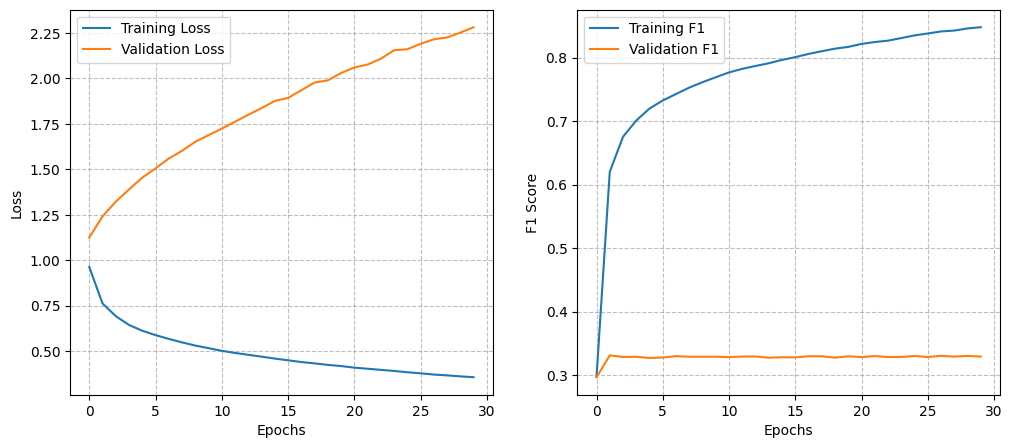

In [41]:
#If training was just performed we can plot the training graphs here

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

plt.subplot(1,2,2)
plt.plot(train_acc, label = 'Training F1')
plt.plot(val_acc, label = 'Validation F1')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

plt.show()

#### Evaluating LSTM

In [39]:
lstm_model.to(DEVICE)
lstm_model.eval()

test_tweets = tweets_test
test_labels = sentiment_test

X_test = torch.tensor(lstm_tokenizer.transform(test_tweets)).long().to(DEVICE)
Y_test = torch.tensor(test_labels.values).long().to(DEVICE)

with torch.no_grad():
    test_pred = lstm_model(X_test)

    test_pred_labels = test_pred.argmax(dim=-1).cpu().numpy()


lstm_report = classification_report(test_labels, test_pred_labels, output_dict=True)
for k in sorted(lstm_report.keys()):
    print(k, lstm_report[k])

lstm_cm = confusion_matrix(test_labels, test_pred_labels)
print(lstm_cm)

0 {'precision': 0.8319950586781965, 'recall': 0.7908907901358833, 'f1-score': 0.81092238228338, 'support': 11922}
1 {'precision': 0.8943244387971199, 'recall': 0.831899665112614, 'f1-score': 0.861983330498384, 'support': 15229}
2 {'precision': 0.8464144320639974, 'recall': 0.9076108363604534, 'f1-score': 0.8759450897571278, 'support': 22849}
accuracy 0.85672
macro avg {'precision': 0.8575779765131045, 'recall': 0.8434670972029835, 'f1-score': 0.8496169341796306, 'support': 50000}
weighted avg {'precision': 0.8575687065246614, 'recall': 0.85672, 'f1-score': 0.8561886027520592, 'support': 50000}
[[ 9429   583  1910]
 [  707 12669  1853]
 [ 1197   914 20738]]
